## SMT Mini EDA

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-11-19 14:06:03.996734: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 14:06:05.047395: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 14:06:05.570316: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 14:06:05.571372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *
from collections import defaultdict

Resorting genes by reference genome order


#### Check job specs

In [5]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 7.0%
RAM Usage: 3.2%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


## Data load

In [23]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels

from models.bilinear import BilinearCM, BilinearLowRank
from models.dynamic_mlp import DynamicMLP
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel
from models.smt_cross import CrossAttentionGeneVecModel, MixedAttentionGeneVecModel, SelfAttentionGeneVecModel

# Load data
print("Loading data...")

full_gene_list='0.2'
hvg_gene_list='100_var'

# Load two versions of gene expression data based on gene lists
X_full, valid_genes_full = load_transcriptome(parcellation='S456', gene_list=full_gene_list, hemisphere='both', omit_subcortical=False, sort_genes='expression', impute_strategy='mirror_interpolate', return_valid_genes=True)
X_hvg, valid_genes_hvg = load_transcriptome(parcellation='S456', gene_list=hvg_gene_list, hemisphere='both', omit_subcortical=False, sort_genes='expression', impute_strategy='mirror_interpolate', return_valid_genes=True)

Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X_full).all(axis=1)

# Subset all data using valid indices
X_full_valid = X_full[valid_indices]
X_hvg_valid = X_hvg[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# prepare data loaders for each type
X_full = torch.tensor(X_full_valid, dtype=torch.float32).to("cuda")
X_hvg = torch.tensor(X_hvg_valid, dtype=torch.float32).to("cuda")
coords = torch.tensor(coords_valid, dtype=torch.float32).to("cuda")

# Create datasets
dataset_full = TensorDataset(X_full, coords)
dataset_hvg = TensorDataset(X_hvg, coords)

# Create dataloaders
dataloader_full = DataLoader(dataset_full, batch_size=X_full_valid.shape[0], shuffle=False)
dataloader_hvg = DataLoader(dataset_hvg, batch_size=X_hvg_valid.shape[0], shuffle=False)

Loading data...
Resorting genes by expression level
Resorting genes by expression level


In [24]:
from data.data_utils import RegionPairDataset

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Create full pairwise dataset
print("Creating full and HVG pairwise datasets...")

# Create full pairwise dataset
full_dataset = RegionPairDataset(
    X=X_full_valid,
    Y=Y_valid, 
    coords=coords_valid,
    dataset='UKBB',
    parcellation='S456',
    valid2true_mapping=valid2true_mapping,
    valid_genes=valid_genes_full
)

# Create HVG pairwise dataset
hvg_dataset = RegionPairDataset(
    X=X_hvg_valid,
    Y=Y_valid,
    coords=coords_valid, 
    dataset='UKBB',
    parcellation='S456',
    valid2true_mapping=valid2true_mapping,
    valid_genes=valid_genes_hvg
)

print(f"Full dataset: {len(full_dataset)} region pairs")
print(f"HVG dataset: {len(hvg_dataset)} region pairs")

# Create dataloaders
full_dataloader = DataLoader(
    full_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

hvg_dataloader = DataLoader(
    hvg_dataset,
    batch_size=512, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Creating full and HVG pairwise datasets...


Full dataset: 206570 region pairs
HVG dataset: 206570 region pairs


Initialize models

In [25]:

# Shared Transformer (only for full gene list)
shared_transformer_full = SharedSelfAttentionModel(
    input_dim=X_full.shape[1]*2,
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    use_alibi=True,
    nhead=4,
    num_layers=4,
    deep_hidden_dims=[512, 256, 128],
    transformer_dropout=0.2,
    dropout_rate=0.2,
    learning_rate=0.00009,
    weight_decay=0.0001
).to('cuda')


# Self Attention GeneVec
self_attention_hvg = SelfAttentionGeneVecModel(
    input_dim=X_hvg.shape[1],
    region_pair_dataset=hvg_dataset,
    expression_bins=100,
    genevec_type='one_hot',
    d_model=32,
    nhead=2,
    num_layers=2,
    deep_hidden_dims=[256, 128, 64],
    pooling_mode='linear',
    use_alibi=True,
    transformer_dropout=0.1,
    dropout_rate=0.1,
    learning_rate=0.00009,
    weight_decay=0.00001
    ).to('cuda')

# Cross Attention GeneVec
mixed_attention_hvg = MixedAttentionGeneVecModel(
    input_dim=X_hvg.shape[1],
    region_pair_dataset=hvg_dataset,
    expression_bins=100,
    genevec_type='one_hot',
    d_model=32,
    nhead=2,
    num_layers=2,
    deep_hidden_dims=[256, 128, 64],
    pooling_mode='linear',
    use_alibi=True,
    transformer_dropout=0.1,
    dropout_rate=0.1,
    learning_rate=0.00009,
    weight_decay=0.00001
    ).to('cuda')


# Cross Attention GeneVec
cross_attention_hvg = CrossAttentionGeneVecModel(
    input_dim=X_hvg.shape[1],
    region_pair_dataset=hvg_dataset,
    expression_bins=5,
    genevec_type='gene2vec',
    d_model=32,
    nhead=2,
    num_layers=2,
    deep_hidden_dims=[256, 128, 64],
    pooling_mode='attention',
    use_alibi=True,
    transformer_dropout=0.1,
    dropout_rate=0.1,
    learning_rate=0.00009,
    weight_decay=0.00001,
    bidirectional=True
    ).to('cuda')

  warnings.warn(



Number of learnable parameters in SMT model: 2162315
Using SymmetricLoss with lambda_sym=0.1
Created one-hot embeddings: 100 genes with 100-dimensional embeddings
Using all valid genes for one-hot encoding
Number of learnable parameters in SelfAttentionGeneVec model: 125474
Expression bins: 100
Pooling mode: linear
ROI combination: concat
Using SymmetricLoss with lambda_sym=0.1
Created one-hot embeddings: 100 genes with 100-dimensional embeddings
Using all valid genes for one-hot encoding
Number of learnable parameters in MixedAttentionGeneVec model: 125602
Expression bins: 100
Region embedding initialization: spatial
Using SymmetricLoss with lambda_sym=0.1


  warnings.warn(



Loaded Gene2Vec embeddings: 94 genes with 200-dimensional embeddings
Gene overlap: 94/100 valid genes have Gene2Vec embeddings
Number of learnable parameters in CrossAttentionGeneVec model: 85730
Expression bins: 5
Pooling mode: attention


Visualize cross-attention

In [64]:
# RETRAIN THIS

# Load pretrained Cross Attention GeneVec model
cross_attention_hvg = CrossAttentionGeneVecModel(
    input_dim=X_hvg.shape[1],
    region_pair_dataset=hvg_dataset,
    expression_bins=5,
    genevec_type='one_hot',
    d_model=32,
    nhead=2,
    num_layers=2,
    deep_hidden_dims=[256, 128, 64],
    cls_init='random',
    pooling_mode='attention',
    use_alibi=True,
    transformer_dropout=0.3,
    dropout_rate=0.1,
    learning_rate=0.00009,
    weight_decay=0.001,
    bidirectional=True
).to('cuda')

# Load saved model weights
cross_attention_hvg.load_state_dict(torch.load('models/saved_models/UKBB_cross_full.pt'))


# Create HVG pairwise dataset
hvg_dataset = RegionPairDataset(
    X=X_hvg_valid,
    Y=Y_valid,
    coords=coords_valid, 
    dataset='UKBB',
    parcellation='S456',
    valid2true_mapping=valid2true_mapping,
    valid_genes=valid_genes_hvg
)


# Create loader for full dataset
test_loader = DataLoader(hvg_dataset, batch_size=512, shuffle=False, num_workers=2)

# Extract attention weights using your loaded model
predictions, targets, avg_attn = cross_attention_hvg.predict(test_loader, collect_attn=True)

# Get individual heads and global average
individual_heads, global_average = cross_attention_hvg.get_attention_heads(avg_attn)

# Now you can analyze the attention patterns
print(f"Number of attention heads: {len(individual_heads)}")
print(f"Shape of each head: {individual_heads[0].shape}")
print(f"Shape of global average: {global_average.shape}")

fig, axes = plt.subplots(1, len(individual_heads) + 1, figsize=(15, 4))

# Plot individual heads
for i, head in enumerate(individual_heads):
    im = axes[i].imshow(head, cmap='viridis', aspect='auto')
    axes[i].set_title(f'Cross-Attention Head {i}')
    axes[i].set_xlabel('Key Genes (Region J)')
    axes[i].set_ylabel('Query Genes (Region I)')
    plt.colorbar(im, ax=axes[i])

# Plot global average
im = axes[-1].imshow(global_average, cmap='viridis', aspect='auto')
axes[-1].set_title('Global Average')
axes[-1].set_xlabel('Key Genes (Region J)')
axes[-1].set_ylabel('Query Genes (Region I)')
plt.colorbar(im, ax=axes[-1])

plt.tight_layout()
plt.show()

# Example: analyze attention statistics
for i, head in enumerate(individual_heads):
    print(f"Head {i}: mean={head.mean():.4f}, max={head.max():.4f}, std={head.std():.4f}")

print(f"Global average: mean={global_average.mean():.4f}, max={global_average.max():.4f}")

# Example: find most attended gene pairs
# Get top 10 most attended gene pairs in global average
flat_indices = np.argsort(global_average.flatten())[-10:]
top_pairs = np.unravel_index(flat_indices, global_average.shape)

print("\nTop 10 most attended gene pairs (query_gene_idx, key_gene_idx):")
for i in range(10):
    query_idx = top_pairs[0][-(i+1)]
    key_idx = top_pairs[1][-(i+1)]
    attention_weight = global_average[query_idx, key_idx]
    print(f"  Gene {query_idx} -> Gene {key_idx}: {attention_weight:.4f}")



TypeError: CrossAttentionGeneVecModel.__init__() got an unexpected keyword argument 'cls_init'

### SMT mini self attention analysis

In [87]:
from models.smt_cross import SelfAttentionGeneVecModel

# Load pretrained Cross Attention GeneVec model
self_attention_hvg = SelfAttentionGeneVecModel(
    input_dim=X_hvg.shape[1],
    region_pair_dataset=hvg_dataset,
    expression_bins=100,
    genevec_type='one_hot',
    d_model=32,
    nhead=2,
    num_layers=2,
    deep_hidden_dims=[256, 128, 64],
    pooling_mode='linear',
    use_alibi=True,
    transformer_dropout=0.1,
    dropout_rate=0.1,
    learning_rate=0.00009,
    weight_decay=0.00001
).to('cuda')

# Load saved model weights
self_attention_hvg.load_state_dict(torch.load('models/saved_models/UKBB_self_linear_pool2.pt'))

# Create HVG pairwise dataset
hvg_dataset = RegionPairDataset(
    X=X_hvg_valid,
    Y=Y_valid,
    coords=coords_valid, 
    dataset='UKBB',
    parcellation='S456',
    valid2true_mapping=valid2true_mapping,
    valid_genes=valid_genes_hvg
)


  warnings.warn(



Using SymmetricLoss with lambda_sym=0.1
Created one-hot embeddings: 100 genes with 100-dimensional embeddings
Using all valid genes for one-hot encoding
Number of learnable parameters in SelfAttentionGeneVec model: 125474
Expression bins: 100
Pooling mode: linear
ROI combination: concat


Exception ignored in: <function ExactWeakKeyDictionary.__setitem__.<locals>.<lambda> at 0x7fba8549ea20>
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.11/site-packages/torch/_dynamo/utils.py", line 478, in <lambda>
    self.refs[idx] = weakref.ref(key, lambda ref: self._remove_id(idx))
                                                  ^^^^^^^^^^^^^^^^^^^^
  File "/ext3/miniconda3/lib/python3.11/site-packages/torch/_dynamo/utils.py", line 775, in _remove_id
    hook()
  File "/ext3/miniconda3/lib/python3.11/site-packages/torch/_dynamo/utils.py", line 759, in __call__
    del self.scope[self.name]
        ~~~~~~~~~~^^^^^^^^^^^
KeyError: '__builtins_dict___84'
Exception ignored in: <function ExactWeakKeyDictionary.__setitem__.<locals>.<lambda> at 0x7fba8581cd60>
Traceback (most recent call last):
  File "/ext3/miniconda3/lib/python3.11/site-packages/torch/_dynamo/utils.py", line 478, in <lambda>
    self.refs[idx] = weakref.ref(key, lambda ref: self._remove_id(idx

Embedding list shape: (455, 100)
Raw expression shape: (455, 100)


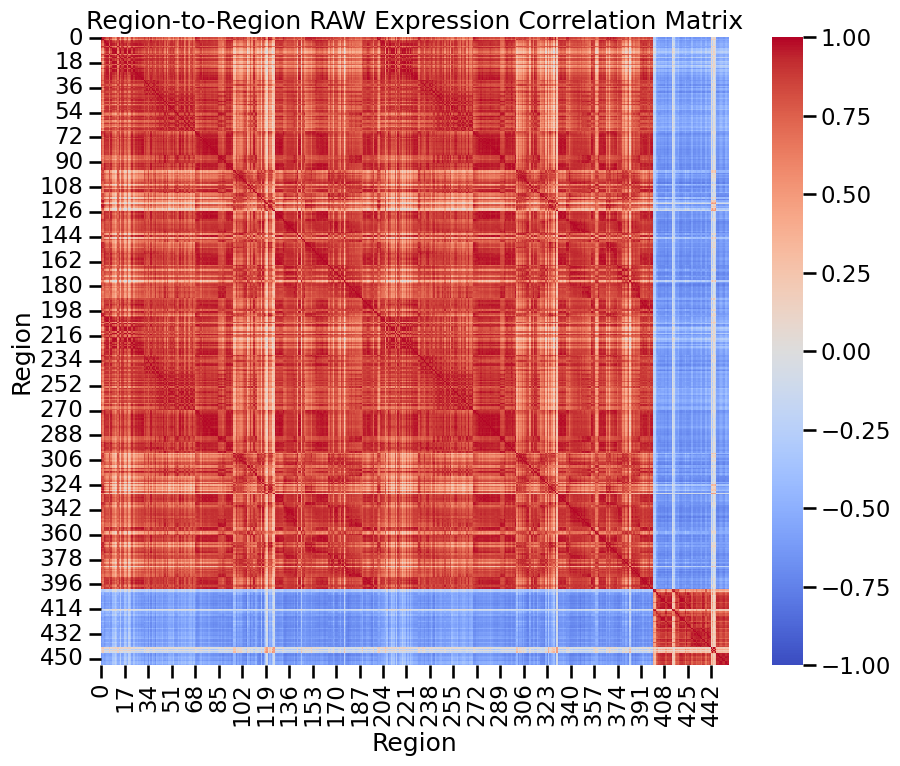

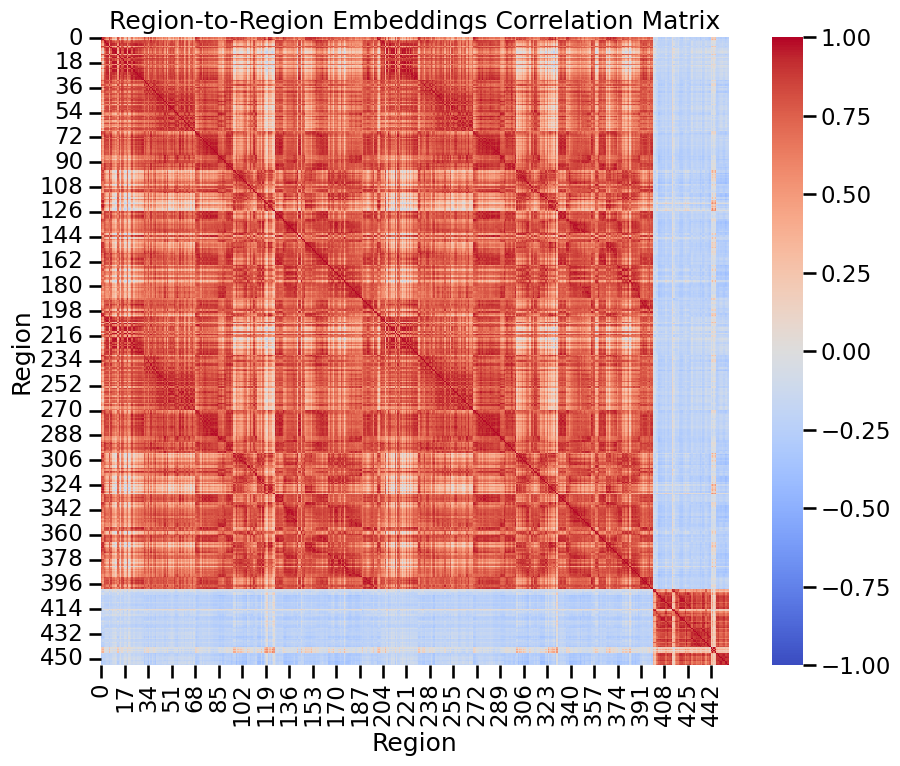

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



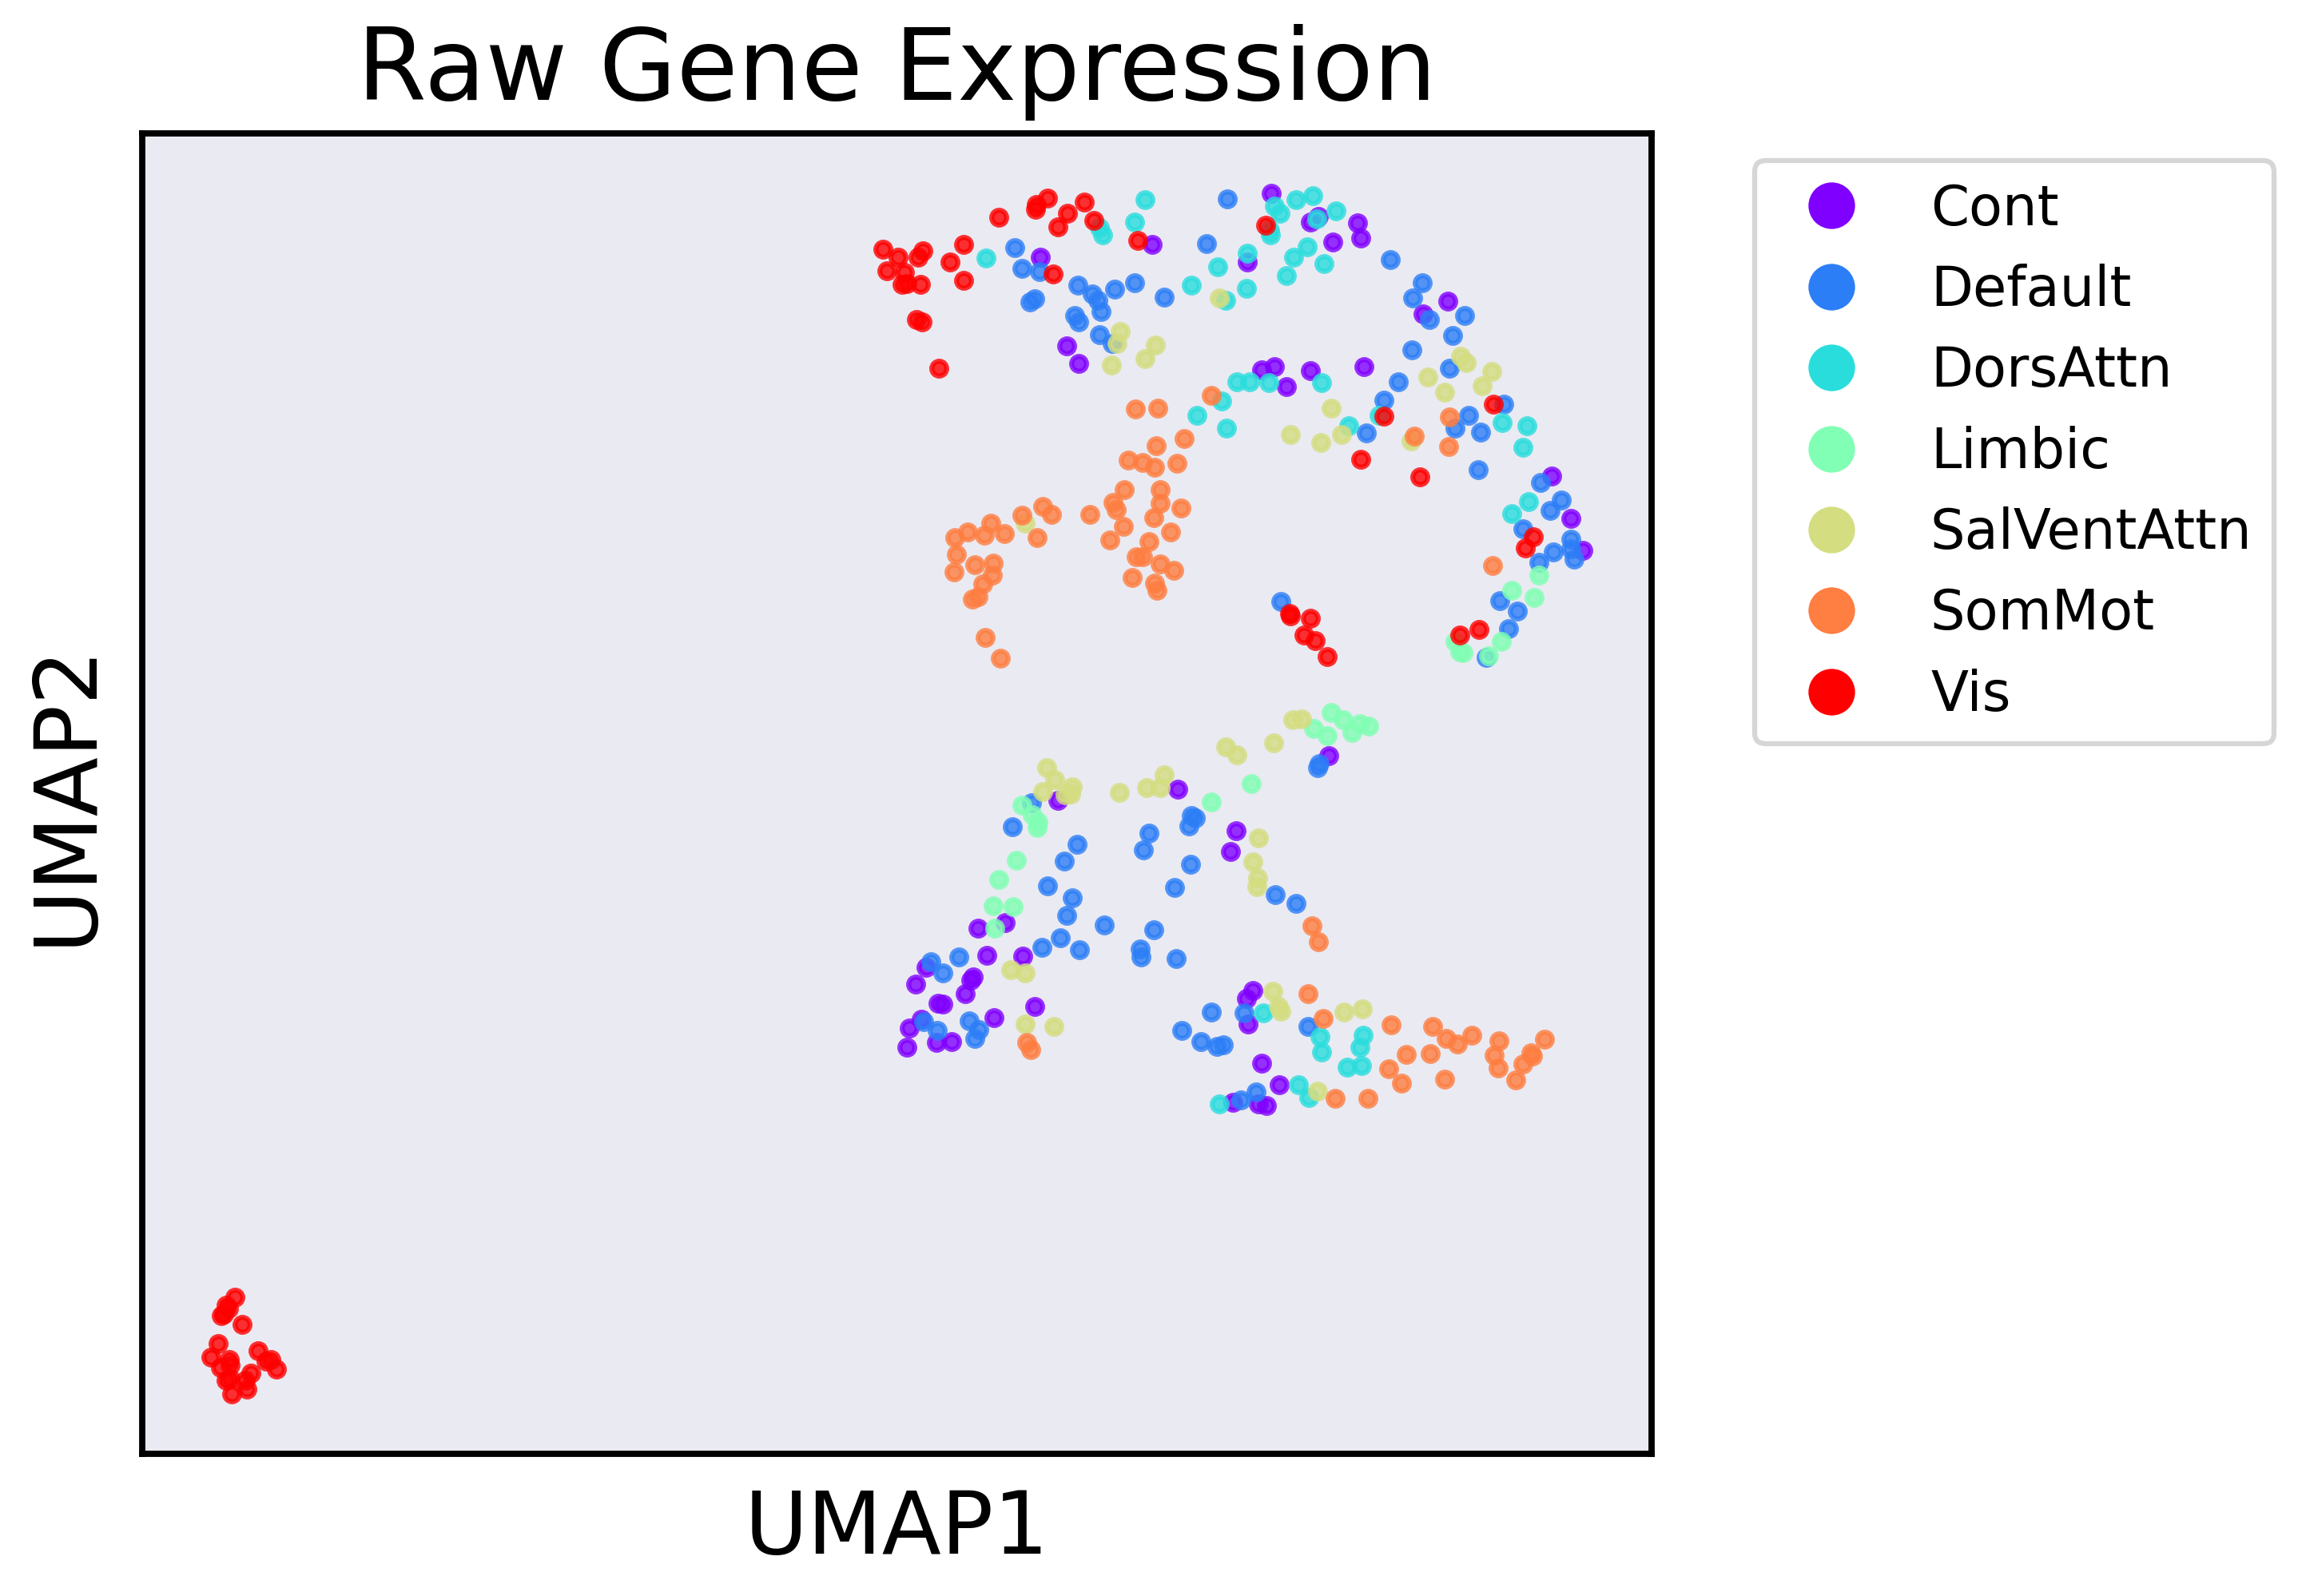

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



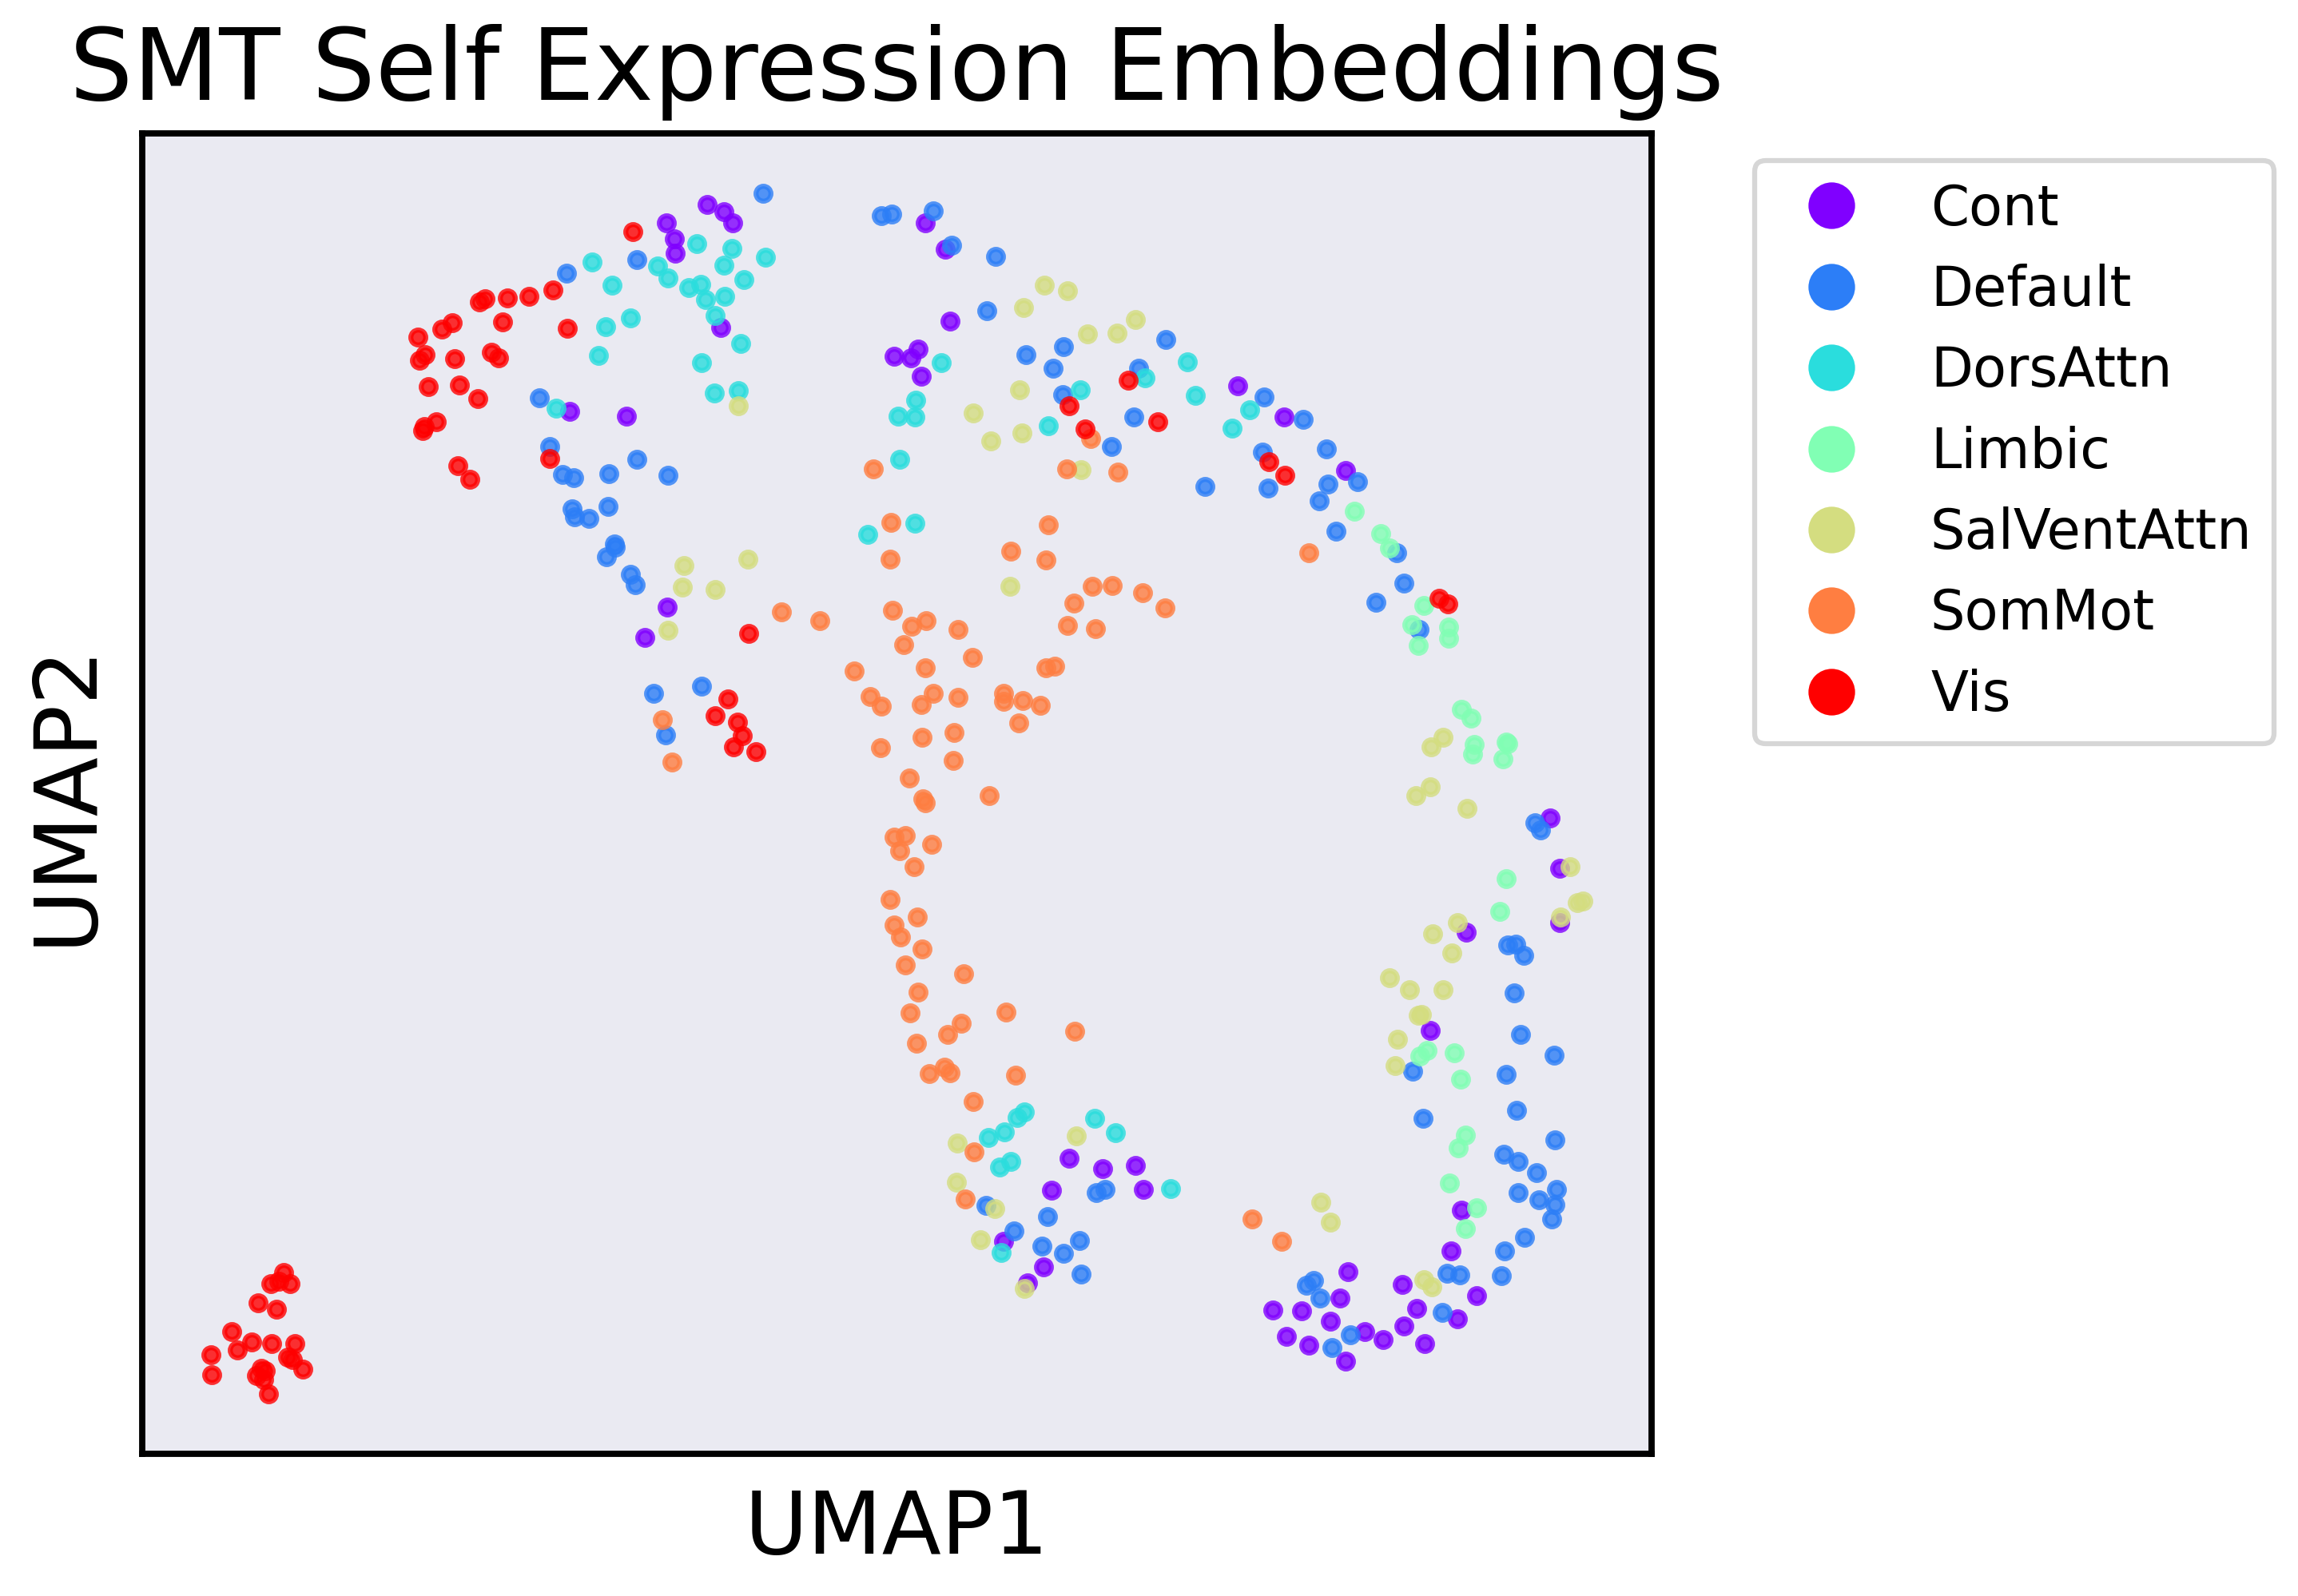

In [88]:
# --- Script-like analysis for any passed-in self_attention_hvg model variant ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from data.data_viz import plot_coords_w_fc, plot_umap_embeddings_w_fc

# Fetch a batch and get embeddings via encoder
embeddings_list = []

with torch.no_grad():
    for batch in dataloader_hvg:
        gene_expr_i = batch[0].to('cuda')
        # NOTE: assumes model encoder inputs gene_expr_i as both arguments (update as needed)
        embedding_i = self_attention_hvg.encoder(gene_expr_i, gene_expr_i).cpu().numpy()
        # Truncate or use full embedding as appropriate for the model
        embeddings_list.append(embedding_i[:, :100] if embedding_i.shape[1] >= 100 else embedding_i)
        break  # Only need one batch for visualizations

embeddings_list = np.array(embeddings_list).reshape(-1, embeddings_list[0].shape[1])
print("Embedding list shape:", embeddings_list.shape)

# ---- Raw gene expression correlation matrix ----
raw_expr = gene_expr_i.cpu().numpy()  # shape: (num_regions, num_genes)
print("Raw expression shape:", raw_expr.shape)

corr_matrix_raw = np.corrcoef(raw_expr)  # shape (num_regions, num_regions)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_raw, vmin=-1, vmax=1, cmap='coolwarm', square=True)
plt.title("Region-to-Region RAW Expression Correlation Matrix")
plt.xlabel("Region")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

# ---- Embedding correlation matrix ----
corr_matrix = np.corrcoef(embeddings_list)  # shape (num_regions, num_regions)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm', square=True)
plt.title("Region-to-Region Embeddings Correlation Matrix")
plt.xlabel("Region")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

# ---- UMAP/Embedding Visualizations ----

plot_umap_embeddings_w_fc(
    raw_expr, 
    network_labels, 
    conn_matrix=Y_valid, 
    title="Raw Gene Expression",  
    omit_subcortical=True, 
    edge_alpha=0.3, 
    edge_width=0.5, 
    enhance_legend=False
)

plot_umap_embeddings_w_fc(
    embeddings_list, 
    network_labels, 
    conn_matrix=Y_valid, 
    title="SMT Self Expression Embeddings", 
    omit_subcortical=True, 
    edge_alpha=0.3, 
    edge_width=0.5, 
    enhance_legend=False
)


Visualize attention heads

Collect attention

Resorting genes by reference genome order


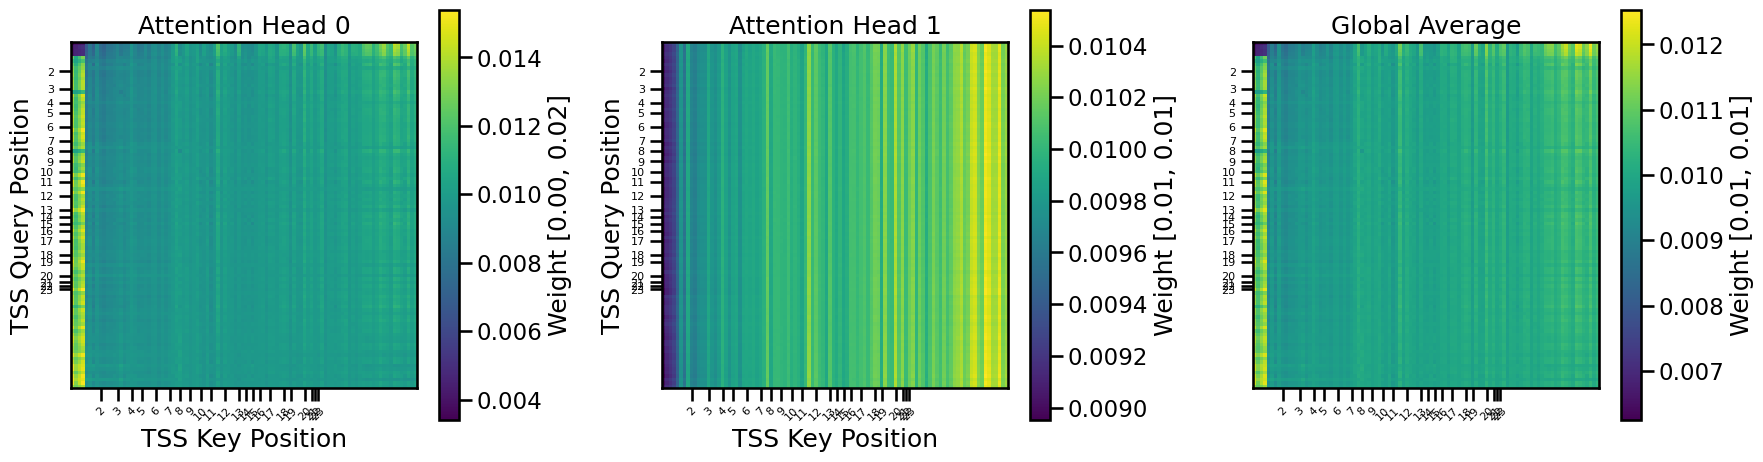

Resorting genes by reference genome order


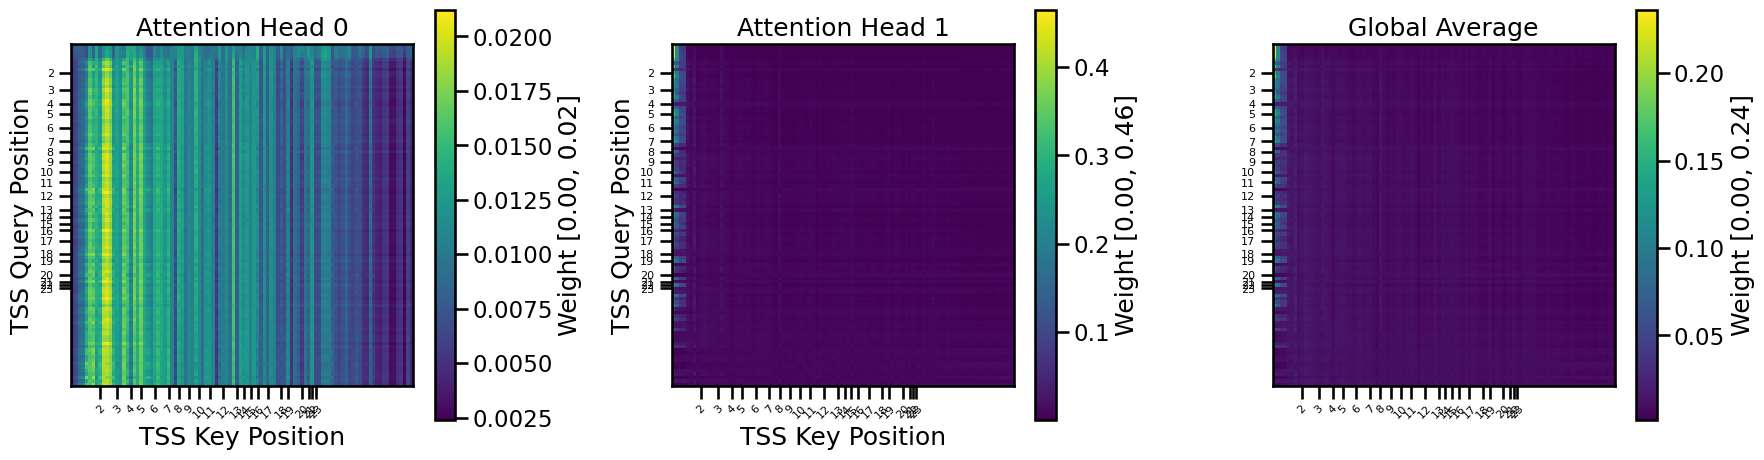

In [108]:
# Run inference and collect self-attention maps
predictions, targets, avg_attn_layer0 = self_attention_hvg.predict(
    hvg_dataloader,
    collect_attn=True,  # collect attention during prediction
    save_attn_path=None,
    layer_idx=0
)

# Run inference and collect self-attention maps
predictions, targets, avg_attn_layer1 = self_attention_hvg.predict(
    hvg_dataloader,
    collect_attn=True,  # collect attention during prediction
    save_attn_path=None,
    layer_idx=1
)

In [115]:
def visualize_attention_heads(attn, gene_names=None):
    """
    Visualize self-attention maps for all heads and also the global average, 
    mimicking the simple style of the code in file_context_0.

    Args:
        attn (np.ndarray or torch.Tensor): (num_heads, num_genes, num_genes) attention array
        gene_names (list of str or None): Optional names of genes for axis labeling
    """
    if isinstance(attn, torch.Tensor):
        attn = attn.cpu().numpy()

    num_heads = attn.shape[0]
    num_genes = attn.shape[1]

    if gene_names is None:
        gene_names = [f"Gene{i}" for i in range(num_genes)]

    fig, axes = plt.subplots(1, num_heads+1, figsize=(4*(num_heads+1), 4))
    if num_heads == 1:
        axes = np.array([axes])

    for h in range(num_heads):
        ax = axes[h]
        im = ax.imshow(attn[h], cmap="viridis", interpolation='none')
        ax.set_title(f"Head {h}")
        ax.set_xlabel("Key Gene")
        ax.set_ylabel("Query Gene")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Top 10 queried genes with highest average attention (per head)
        avg_per_query = attn[h].mean(axis=1)
        top_q_idxs = np.argsort(avg_per_query)[::-1][:10]
        top_q_names = [gene_names[i] for i in top_q_idxs]
        print(f"Head {h} - Top 10 Query Genes: {top_q_names}")

        # Top 10 attended genes (i.e., keys with highest mean attention)
        avg_per_key = attn[h].mean(axis=0)
        top_k_idxs = np.argsort(avg_per_key)[::-1][:10]
        top_k_names = [gene_names[i] for i in top_k_idxs]
        print(f"Head {h} - Top 10 Attended Genes: {top_k_names}")

    # Plot global average attention map (across heads)
    global_attn = attn.mean(axis=0)
    ax = axes[-1]
    im = ax.imshow(global_attn, cmap="viridis", interpolation='none')
    ax.set_title("Global Avg. Attention (across heads)")
    ax.set_xlabel("Key Gene")
    ax.set_ylabel("Query Gene")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Top 10 query and attended genes for global average
    avg_per_query = global_attn.mean(axis=1)
    top_q_idxs = np.argsort(avg_per_query)[::-1][:10]
    top_q_names = [gene_names[i] for i in top_q_idxs]
    print(f"Global - Top 10 Query Genes: {top_q_names}")

    avg_per_key = global_attn.mean(axis=0)
    top_k_idxs = np.argsort(avg_per_key)[::-1][:10]
    top_k_names = [gene_names[i] for i in top_k_idxs]
    print(f"Global - Top 10 Attended Genes: {top_k_names}")

    plt.tight_layout()
    plt.show()

Head 0 - Top 10 Query Genes: ['CRNDE', 'SLC17A7', 'BAIAP2L2', 'ADCY2', 'C3orf80', 'PP12613', 'KCNIP3', 'RHEBL1', 'LRRC8B', 'STAC2']
Head 0 - Top 10 Attended Genes: ['GPRIN2', 'CRNDE', 'PIRT', 'CHRNA3', 'OLFM1', 'STX1A', 'RGS4', 'HSPB3', 'TESPA1', 'NUAK1']
Head 1 - Top 10 Query Genes: ['GALNTL5', 'MET', 'NPPA', 'HOMER1', 'LMO4', 'GDA', 'C3orf80', 'BAIAP2L2', 'ADTRP', 'CA11']
Head 1 - Top 10 Attended Genes: ['STX1A', 'OLFM1', 'HSPB3', 'TESPA1', 'RGS4', 'ITPR1', 'LINC02217', 'KCNS1', 'EPOP', 'NUAK1']
Global - Top 10 Query Genes: ['SLN', 'NUAK1', 'TNNT2', 'KIAA1549L', 'MET', 'COX7A1', 'CAMKK2', 'EPHB6', 'LOC105376360', 'CCKBR']
Global - Top 10 Attended Genes: ['GPRIN2', 'CRNDE', 'PIRT', 'STX1A', 'OLFM1', 'HSPB3', 'RGS4', 'TESPA1', 'NUAK1', 'ITPR1']


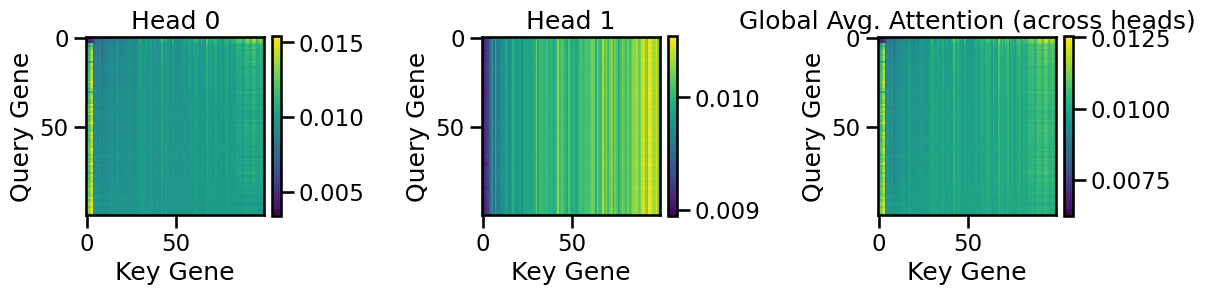

In [116]:
visualize_attention_heads(avg_attn_layer0, gene_names=valid_genes_hvg)

Head 0 - Top 10 Query Genes: ['MCHR2', 'STAC2', 'LY86-AS1', 'MAPK10', 'MLIP', 'GALNTL5', 'NGEF', 'C1orf115', 'CDKL1', 'ADTRP']
Head 0 - Top 10 Attended Genes: ['TNNT2', 'ABCC12', 'MCHR2', 'LYPD8', 'NEUROD2', 'FREM3', 'TBR1', 'FHL2', 'ITPKA', 'ATP4A']
Head 1 - Top 10 Query Genes: ['EXTL1', 'FLJ33534', 'SLC26A4-AS1', 'CCK', 'SV2B', 'CABP1', 'KCNV1', 'C3orf80', 'RTN4RL2', 'NPTX1']
Head 1 - Top 10 Attended Genes: ['CRNDE', 'CHRNA3', 'PIRT', 'GPRIN2', 'ATP4A', 'SLN', 'LINC01296', 'ABCC12', 'OVOL2', 'FREM3']
Global - Top 10 Query Genes: ['EXTL1', 'DIRAS2', 'CDKL1', 'NGEF', 'ENC1', 'LY86-AS1', 'FLJ33534', 'CHN1', 'SLC26A4-AS1', 'FBXW7']
Global - Top 10 Attended Genes: ['CRNDE', 'CHRNA3', 'GPRIN2', 'PIRT', 'ATP4A', 'ABCC12', 'SLN', 'TNNT2', 'LINC01296', 'FREM3']


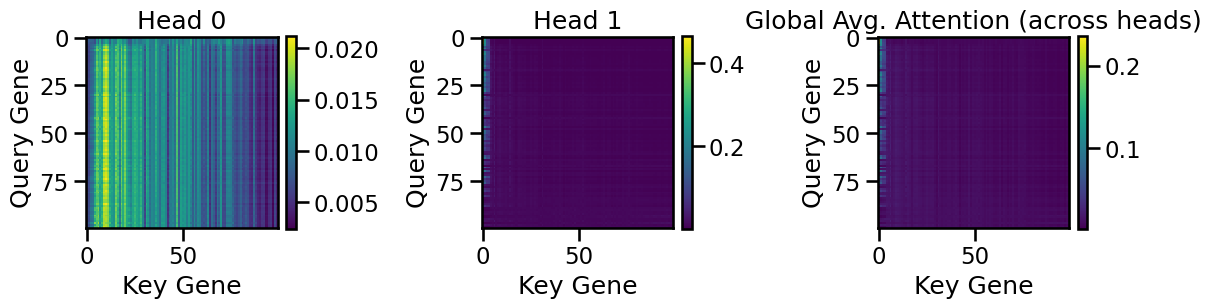

In [117]:
visualize_attention_heads(avg_attn_layer1, gene_names=valid_genes_hvg)

Analyze how the SMT-self mini represents each gene

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from models.smt_cross import BaseGeneVecEncoder
from sklearn.decomposition import PCA

# ---- Extract gene2vec signatures and ensure ALL downstream analysis uses only these genes ----

# 1. Gene2Vec Embeddings (sets canonical gene set)
encoder_gene2vec = BaseGeneVecEncoder(
    valid_genes=list(valid_genes_hvg),
    genevec_type='gene2vec',
    expression_bins=5,
    d_model=32,
    device='cpu',
)
gene2vec_shared_genes = encoder_gene2vec.shared_genes  # canonical gene order
gene2vec_emb_full = encoder_gene2vec.genevec_embeddings.cpu().numpy()  # (num_gene2vec_genes, D_orig)

canonical_genes = list(gene2vec_shared_genes)

# 2. Coexpression Embeddings (restricted to gene2vec genes)
encoder_coexpression = BaseGeneVecEncoder(
    valid_genes=canonical_genes,
    genevec_type='coexpression',
    expression_bins=5,
    d_model=32,
    device='cpu',
)
coexpr_emb_full = encoder_coexpression.genevec_embeddings.cpu().numpy()
coexpression_genes = encoder_coexpression.shared_genes  # should match canonical_genes

# 3. Model's Learned Gene Embeddings, indexed using canonical_genes order
valid_genes_subset = list(valid_genes_hvg)
mdl_gene_idx = {g:i for i, g in enumerate(valid_genes_subset)}
model_emb_all = self_attention_hvg.encoder.genevec_projection.weight.detach().cpu().numpy().T
model_emb = np.array([model_emb_all[mdl_gene_idx[g]] for g in canonical_genes])

# --- Final gene set checks
assert list(canonical_genes) == list(coexpression_genes)
assert len(model_emb) == len(gene2vec_emb_full) == len(coexpr_emb_full) == len(canonical_genes)
d_model = model_emb.shape[1]

# --- PCA reduce gene2vec and coexpression vectors to d_model dims
def project_to_match(X, output_dim):
    # mean center before PCA
    pca = PCA(n_components=output_dim, random_state=0)
    X_proj = pca.fit_transform(X)
    return X_proj

gene2vec_emb = project_to_match(gene2vec_emb_full, d_model)
coexpr_emb = project_to_match(coexpr_emb_full, d_model)

# --- Compute correlation matrices
corr_gene2vec = np.corrcoef(gene2vec_emb)
corr_coexpr = np.corrcoef(coexpr_emb)
corr_model = np.corrcoef(model_emb)

# --- Clustering (from model emb correlation)
linkage_matrix = linkage(corr_model, method="complete")
leaf_order = leaves_list(linkage_matrix)
corr_model_reordered = corr_model[leaf_order][:, leaf_order]
corr_gene2vec_reordered = corr_gene2vec[leaf_order][:, leaf_order]
corr_coexpr_reordered = corr_coexpr[leaf_order][:, leaf_order]
reordered_gene_names = [canonical_genes[i] for i in leaf_order]

Loaded Gene2Vec embeddings: 94 genes with 200-dimensional embeddings
Gene overlap: 94/100 valid genes have Gene2Vec embeddings
Loaded coexpression embeddings: 94 genes with 7380-dimensional embeddings
Using all valid genes for coexpression embeddings


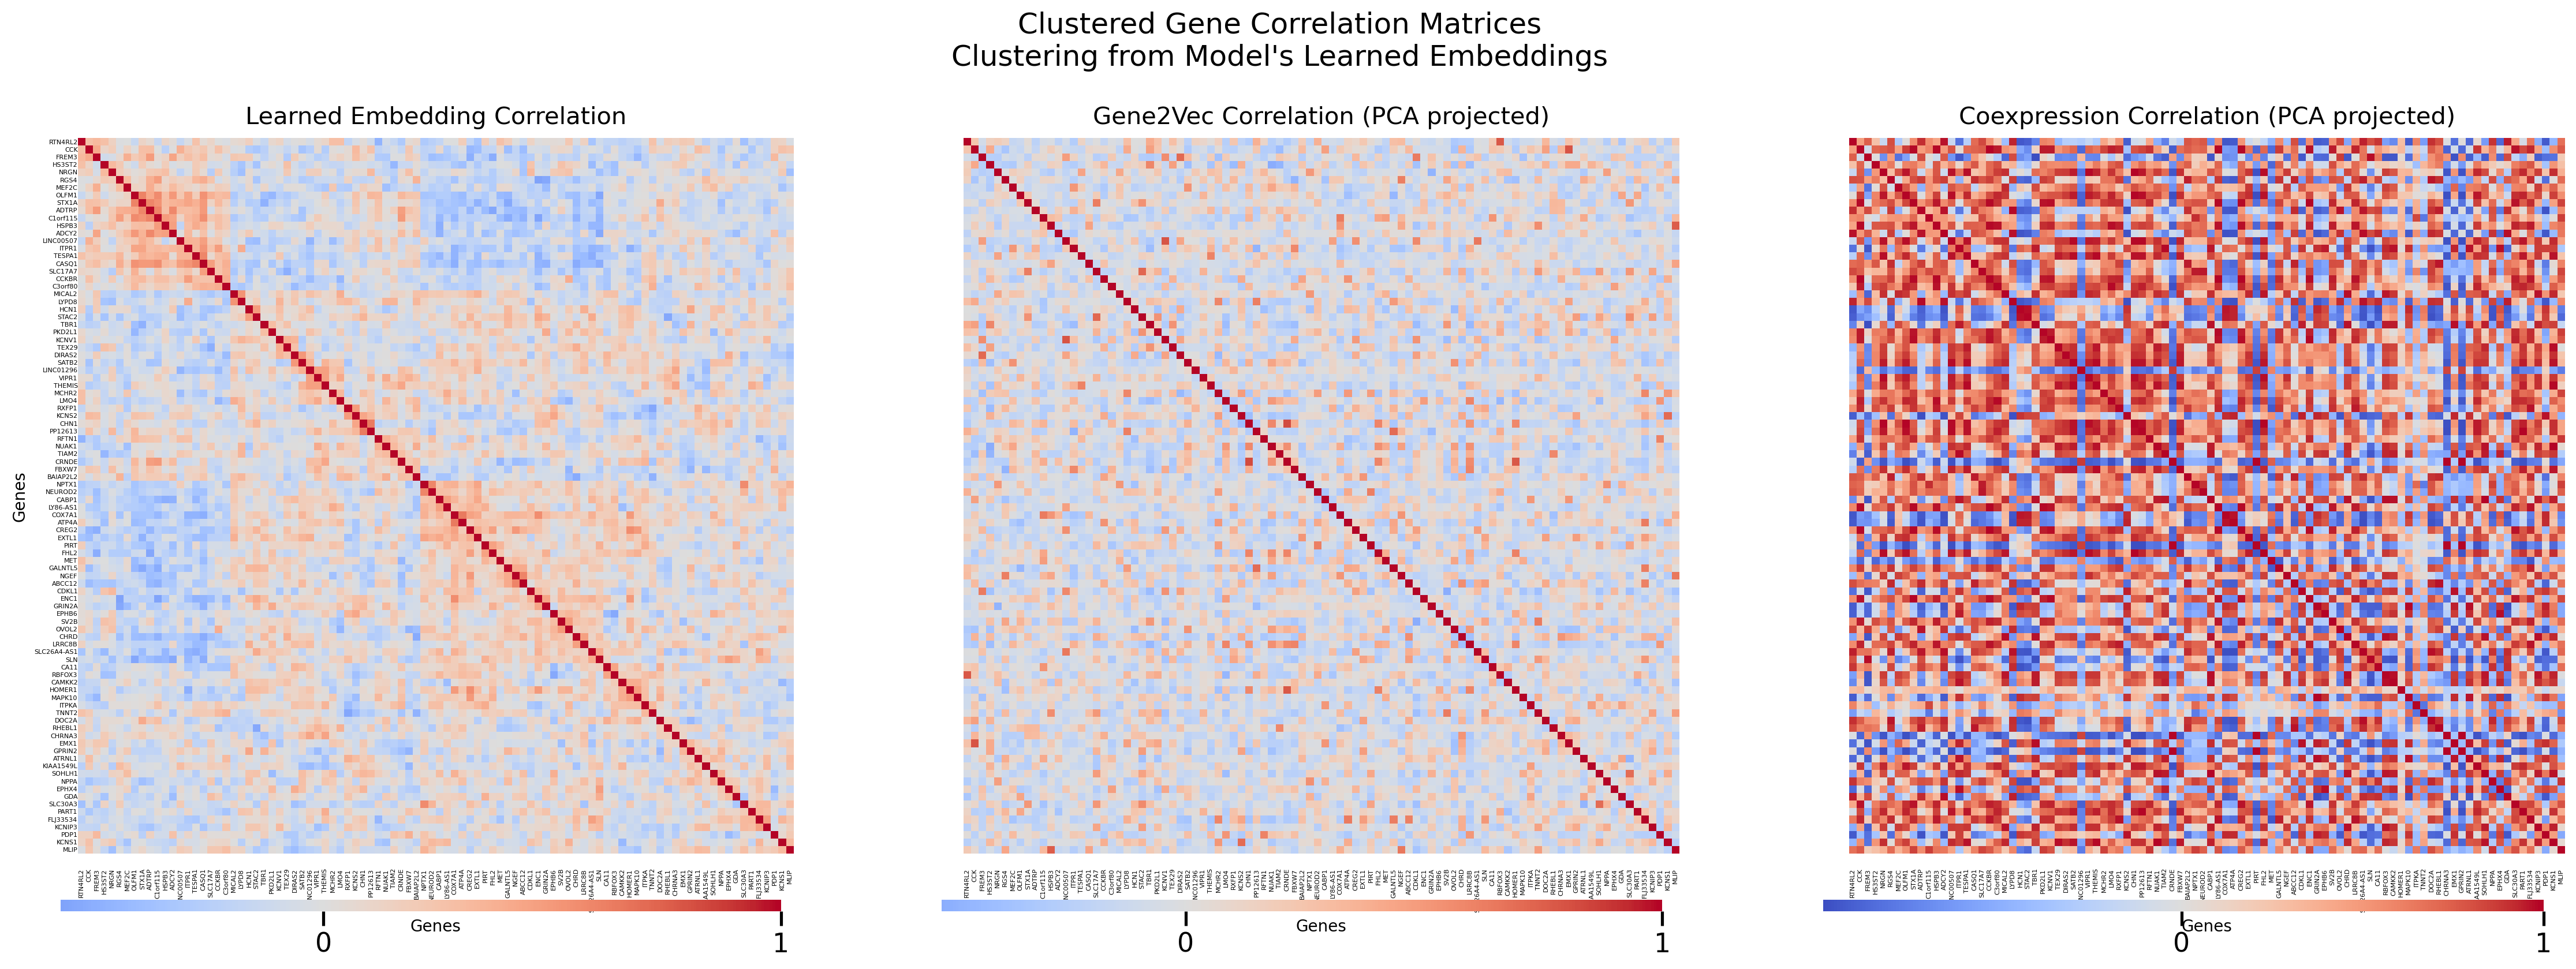

In [143]:

# --- Adjust plot: adapt size/spacing, colorbar and font for more readable heatmaps ---
n_genes = len(reordered_gene_names)
fontsize = 7 if n_genes <= 40 else 5 if n_genes <= 80 else 4

# --- Make the plot less tall: shrink scaling and cap ---
figsize_y = min(10, max(4, 0.22 * n_genes))  # shorter for any gene set

# Increase the DPI for higher resolution
fig, axes = plt.subplots(
    1, 3,
    figsize=(24, figsize_y),
    gridspec_kw={'wspace': 0.18, 'left': 0.06, 'right': 0.97, 'bottom': 0.23, 'top': 0.85},
    dpi=200
)

cbar_kws = dict(fraction=0.02, pad=0.01, aspect=30)

def set_small_ylabel(ax, labels):
    ax.set_yticks(np.arange(len(labels)) + 0.5)
    ax.set_yticklabels(labels, fontsize=fontsize)
    ax.yaxis.set_tick_params(length=0)
    ax.set_ylabel(None)
    ax.tick_params(axis='y', which='major', pad=0)
def set_small_xlabel(ax, labels):
    ax.set_xticks(np.arange(len(labels)) + 0.5)
    ax.set_xticklabels(labels, fontsize=fontsize, rotation=90, va='top')
    ax.set_xlabel(None)
    ax.tick_params(axis='x', which='major', pad=0)

labels = reordered_gene_names

hm0 = sns.heatmap(
    corr_model_reordered, cmap='coolwarm', center=0, square=True, ax=axes[0],
    cbar=True, cbar_ax=fig.add_axes([0.060, 0.18, 0.26, 0.01]), cbar_kws=dict(orientation='horizontal', ticks=[-1,0,1])
)
axes[0].set_title("Learned Embedding Correlation", fontsize=15, pad=9)
set_small_ylabel(axes[0], labels)
set_small_xlabel(axes[0], labels)
axes[0].set_ylabel('Genes', fontsize=10)
axes[0].set_xlabel('Genes', fontsize=10)
axes[0].tick_params(axis="x", bottom=False)
axes[0].tick_params(axis="y", left=False)

hm1 = sns.heatmap(
    corr_gene2vec_reordered, cmap='coolwarm', center=0, square=True, ax=axes[1],
    cbar=True, cbar_ax=fig.add_axes([0.378, 0.18, 0.26, 0.01]), cbar_kws=dict(orientation='horizontal', ticks=[-1,0,1])
)
axes[1].set_title("Gene2Vec Correlation (PCA projected)", fontsize=15, pad=9)
set_small_ylabel(axes[1], labels)
set_small_xlabel(axes[1], labels)
axes[1].set_yticklabels([])
axes[1].set_xlabel('Genes', fontsize=10)
axes[1].tick_params(axis="x", bottom=False)

hm2 = sns.heatmap(
    corr_coexpr_reordered, cmap='coolwarm', center=0, square=True, ax=axes[2],
    cbar=True, cbar_ax=fig.add_axes([0.696, 0.18, 0.26, 0.01]), cbar_kws=dict(orientation='horizontal', ticks=[-1,0,1])
)
axes[2].set_title("Coexpression Correlation (PCA projected)", fontsize=15, pad=9)
set_small_ylabel(axes[2], labels)
set_small_xlabel(axes[2], labels)
axes[2].set_yticklabels([])
axes[2].set_xlabel('Genes', fontsize=10)
axes[2].tick_params(axis="x", bottom=False)

# Add suptitle with padding for readability
fig.suptitle("Clustered Gene Correlation Matrices\nClustering from Model's Learned Embeddings", fontsize=18, y=0.96)
plt.subplots_adjust(wspace=0.18, hspace=0.04)
plt.show()
